In [1]:
import io
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import sentencepiece as spm
import matplotlib.pyplot as plt
from datetime import datetime
from urllib.parse import urlparse
from sklearn.metrics import mean_squared_error

import multiprocessing
import time

from gensim.models import Word2Vec
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

### Preprocess the Data

In [30]:
def dataframe_sentence_generator(df):
    for sentence in df:
        yield sentence.lower()

def extract_domain(url):
    return urlparse(url).netloc

# def extract_day_of_week(url):
#     return urlparse(url).netloc

# Replace 'your_file.csv' with the path to your CSV file
# file_path = './TitlesAndScoreALL.csv'

file_path = './DatasetALLofALL.csv'
df = pd.read_csv(file_path, sep=',')
df['domain'] = df['url'].astype(str).apply(extract_domain)
unique_domains = df['domain'].unique()
unique_domains = {value: index for index, value in enumerate(unique_domains)}

df_sorted = df.sort_values(by='time', ascending=True)

print("Column Headers:", df.columns.tolist())



Column Headers: ['id', 'by', 'type', 'title', 'url', 'score', 'time', 'text', 'parent', 'descendants', 'poll', 'parts', 'kids', 'domain']


In [112]:
# unique_domains = df['domain'].unique()
df['domain_score_avg'] = 0.0
df['by_score_avg'] = 0.0

domain_counts = df['domain'].value_counts()
domains_feature = domain_counts.to_frame(name='count')
domains_feature['score_sum'] = 0
domains_feature['score_num'] = 0


by_counts = df['by'].value_counts()
by_feature = by_counts.to_frame(name='count')
by_feature['score_sum'] = 0
by_feature['score_num'] = 0

for index, row in df.iterrows():

    if row['domain'] in domains_feature.index:
        sum = domains_feature.at[row['domain'], 'score_sum'] + row['score'] 
        num = domains_feature.at[row['domain'], 'score_num'] + 1
        domains_feature.at[row['domain'], 'score_sum'] = sum
        domains_feature.at[row['domain'], 'score_num'] = num

        df.at[index, 'domain_score_avg'] = sum/num
    
    if row['by'] in by_feature.index:
        sum = by_feature.at[row['by'], 'score_sum'] + row['score'] 
        num = by_feature.at[row['by'], 'score_num'] + 1
        by_feature.at[row['by'], 'score_sum'] = sum
        by_feature.at[row['by'], 'score_num'] = num

        df.at[index, 'by_score_avg'] = sum/num

   
# print(domains_feature)
# print(df['domain_score_avg'])
# print(df['by_score_avg'])


In [114]:
# Split the data into training and test sets
train_texts, test_texts, train_score, test_score = train_test_split(
    df[['title', 'domain_score_avg', 'by_score_avg', 'time']],
    df['score'], 
    test_size=0.7, 
    random_state=17
)

In [259]:
# wiki_path = './wikisent2.txt'
# wiki = pd.read_csv(wiki_path, sep='\000', header=None)
# wiki.columns = ['sentence']

In [260]:
# print(wiki.shape)
# print(wiki.squeeze())

### Train a SentencePiece Model

In [261]:
# spm.SentencePieceTrainer.train(
#     input = 'wikisent2.txt',
#     # sentence_iterator=dataframe_sentence_generator(wiki), 
#     model_prefix='spm_Alex_week2', 
#     vocab_size=30000,
# )

In [38]:

sp = spm.SentencePieceProcessor()
sp.load('spm_Alex_week2.model')

True

### Generate  Tokens

In [332]:
tokenized_titles = []
tokenized_domains = []

for text in train_texts.iterrows():
    tokenized_titles.append(sp.encode_as_pieces(text[1]['title']))
    tokenized_domains.append(sp.encode_as_pieces(text[1]['domain']))

In [264]:
wiki_path = './wikisent2.txt'
wiki = pd.read_csv(wiki_path, sep='\000', header=None)
wiki.columns = ['sentence']

In [265]:
tokenized_sentences = []
for sentence in wiki['sentence']:
    tokenized_sentences.append(sp.encode_as_pieces(sentence))

### Use Word2Vec to Generate Embeddings

In [115]:
vector_size = 128

In [116]:

w2v_model = Word2Vec(
    min_count  =20,
    window     =2,
    vector_size=vector_size,
    sample     =6e-5, 
    alpha      = 0.03, 
    min_alpha  = 0.0007, 
    negative   = 20,
    workers    = multiprocessing.cpu_count() - 1
)


### Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them

In [268]:
# w2v_model.build_vocab(tokenized_sentences, progress_per=10000)
# w2v_model.save("word2vec_Alex.model")

In [269]:
# w2v_model.save("word2vec_Alex.model")
# from gensim.models import KeyedVectors

# with open("word2vec_vocab_Alex.txt", 'w') as vocab_file:
#     for word in w2v_model.wv.key_to_index.keys():
#         vocab_file.write(word + '\n')

In [270]:
# w2v_model.train(tokenized_sentences, total_examples=w2v_model.corpus_count, epochs=20, report_delay=1)
# w2v_model.save("word2vec_Alex.model")

In [117]:
w2v_model = Word2Vec.load("word2vec_Alex.model")

In [118]:
similar_words = w2v_model.wv.most_similar('▁hacker', topn=4)
print(similar_words)
print(w2v_model.wv.most_similar(sp.encode_as_pieces('Hacker')))

[('▁programmer', 0.588733971118927), ('▁malware', 0.5806787014007568), ('▁blogger', 0.5462775230407715), ('▁rogue', 0.5439315438270569)]
[('▁Blank', 0.547627866268158), ('▁Egg', 0.5387383699417114), ('ers', 0.5327230095863342), ('▁Behr', 0.5291868448257446), ('▁Hook', 0.5058385729789734), ('▁Licht', 0.49605900049209595), ('▁Krieg', 0.492104709148407), ('▁Pick', 0.49063658714294434), ('▁Blum', 0.4847430884838104), ('▁Wick', 0.48419490456581116)]


In [119]:
def title_to_embedding(sp, title, vector_size):
    tokens = sp.encode_as_pieces(title)

    embeddings = []
    for token in tokens:
        if (token in w2v_model.wv): 
            embeddings.append(w2v_model.wv[token])

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

### Create a PyTorch Dataset

In [148]:
import datetime

def one_hot_encode(number):
    # Ensure the number is within the expected range
    if 0 <= number <= 6:
        # Create a vector of zeros with length 7
        vector = [0] * 7
        # Set the element at the index 'number' to 1
        vector[number] = 1
        return vector
    else:
        raise ValueError("Number must be in range 0 to 23")
    
def one_hot_encode_time(number):
    # Ensure the number is within the expected range
    if 0 <= number <= 23:
        # Create a vector of zeros with length 7
        vector = [0] * 24
        # Set the element at the index 'number' to 1
        vector[number] = 1
        return vector
    else:
        raise ValueError("Number must be in range 0 to 23")

# Example usage



In [149]:

training_embeddings = np.empty((len(train_texts), vector_size+33), dtype=np.float64)
# training_domain_embeddings = np.empty((len(train_texts), vector_size), dtype=np.float64)
testing_embeddings = np.empty((len(test_texts), vector_size+33), dtype=np.float64)
# testing_domain_embeddings = np.empty((len(test_texts), vector_size), dtype=np.float64)
print(len(unique_domains))
for i in range(len(train_texts)):
    row = train_texts.iloc[i]
    
    dt_object = datetime.datetime.fromtimestamp(row['time'])
    day_of_week = dt_object.weekday()
    day_of_week = one_hot_encode(day_of_week) 

    hour = dt_object.hour
    hour = one_hot_encode_time(hour)

    domain_index = np.full(1, row['domain_score_avg'])
    by_index = np.full(1, row['by_score_avg'])
    
    training_embeddings[i] = np.concatenate((title_to_embedding(sp, row['title'], vector_size), domain_index, by_index, day_of_week,hour))
    

for i in range(len(test_texts)):
    row = test_texts.iloc[i]

    dt_object = datetime.datetime.fromtimestamp(row['time'])
    day_of_week = dt_object.weekday()
    day_of_week = one_hot_encode(day_of_week) 

    hour = dt_object.hour
    hour = one_hot_encode_time(hour)

    domain_index = np.full(1, row['domain_score_avg'])
    by_index = np.full(1, row['by_score_avg'])

    testing_embeddings[i] = np.concatenate((title_to_embedding(sp, row['title'], vector_size), domain_index, by_index, day_of_week,hour))
    


33581


In [151]:

print(len(training_embeddings[15]))
print(training_embeddings[15])

161
[ 9.80539322e-02  2.99291700e-01 -4.64470953e-01  9.90907699e-02
 -4.05510843e-01 -9.62891579e-01 -1.46037531e+00  6.21221721e-01
  3.02236024e-02 -4.02983129e-01  4.31129709e-02  8.89236778e-02
  8.97219002e-01  4.22675192e-01 -7.23391175e-02  6.35643750e-02
  1.02461791e+00 -3.61815661e-01 -3.11205238e-01 -6.21531427e-01
  4.17010128e-01  1.80462584e-01 -4.80827004e-01  3.76314104e-01
  1.05210785e-02 -6.44286275e-02 -8.97531867e-01  1.47748303e+00
 -6.22768328e-02 -1.51481628e-01 -1.90545738e-01  6.99174583e-01
 -8.21641326e-01 -7.75107741e-02  8.72147754e-02 -6.42472327e-01
 -5.26288867e-01 -4.54653084e-01  1.51950270e-01  5.79219460e-01
  4.23023812e-02  5.86542964e-01  1.28475070e+00  8.79698634e-01
 -1.19857430e+00 -2.39156246e-01 -6.73063993e-01  3.52889389e-01
  2.83766091e-01 -6.50446832e-01 -3.56094658e-01 -6.48307681e-01
  6.83154315e-02 -1.74866080e-01 -4.28429618e-02  5.56350410e-01
  1.52953938e-01 -1.35878593e-01 -6.66248798e-01 -1.18385243e+00
  1.08920887e-01  2.8

In [152]:
training_input_tensor_embeddings = torch.from_numpy(training_embeddings).float()
testing_input_tensor_embeddings = torch.from_numpy(testing_embeddings).float()

training_target_tensor = torch.from_numpy(train_score.values).view(-1, 1).float()
testing_target_tensor = torch.from_numpy(test_score.values).view(-1, 1).float()

print(training_input_tensor_embeddings.shape)
print(training_input_tensor_embeddings.shape)

print(training_input_tensor_embeddings)
print(training_input_tensor_embeddings)

torch.Size([49626, 161])
torch.Size([49626, 161])
tensor([[ 0.4128, -0.3265,  0.5893,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0154, -0.8625,  0.1227,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3657, -0.9633, -0.4655,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3872,  0.1872,  0.2607,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1397,  0.6612, -0.8060,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.6006, -0.2612,  0.2718,  ...,  0.0000,  0.0000,  1.0000]])
tensor([[ 0.4128, -0.3265,  0.5893,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0154, -0.8625,  0.1227,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3657, -0.9633, -0.4655,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.3872,  0.1872,  0.2607,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.1397,  0.6612, -0.8060,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.6006, -0.2612,  0.2718,  ...,  0.0000,  0.0000,  1.0000]])


### Define and Train the Neural Network

In [154]:
# Define the model
Model = nn.Sequential(
    nn.Linear(vector_size+33, 64),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.Linear(64, 32),
    nn.ReLU(),
    # nn.Dropout(0.5),
    nn.Linear(32, 1)
)

# Set the criterion
criterion = nn.MSELoss()

# Choose the optimizer
optimizer = optim.Adam(
    Model.parameters(), 
    lr=0.002, 
    weight_decay=1e-5,
)

losses_graph = []

epochs = 1000
for epoch in range(1, epochs + 1):
    # Zero the gradients
    Model.train()
    optimizer.zero_grad()
    # Forward pass
    outputs = Model(training_input_tensor_embeddings)
    
    # Calculate loss
    loss = criterion(outputs, training_target_tensor)
    # Print loss every 100 epochs
    if epoch % 10 == 0:
        training_loss = loss.item()
        Model.eval()
        with torch.no_grad():
            test_outputs = Model(testing_input_tensor_embeddings)
            test_loss = criterion(test_outputs, testing_target_tensor)
        print(f'Epoch [{epoch}/{epochs}], \
            Loss: {training_loss} \t \
            Test Loss: {test_loss.item()} \t \
            train: {outputs[0][0].item()} \t \
            Truth: {training_target_tensor[0][0].item()} \t \
            Test: {test_outputs[0][0].item()} \t \
            Truth: {testing_target_tensor[0][0].item()}'
        )
        losses_graph.append([epoch, training_loss, test_loss.item()])

    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    

Epoch [10/1000],             Loss: 293.7621765136719 	             Test Loss: 288.4721984863281 	             train: 0.7058771252632141 	             Truth: 2.0 	             Test: 0.797483503818512 	             Truth: 1.0
Epoch [20/1000],             Loss: 241.23867797851562 	             Test Loss: 237.8692169189453 	             train: 2.723881721496582 	             Truth: 2.0 	             Test: 2.4824817180633545 	             Truth: 1.0
Epoch [30/1000],             Loss: 200.10438537597656 	             Test Loss: 199.88900756835938 	             train: 6.128149509429932 	             Truth: 2.0 	             Test: 5.261690616607666 	             Truth: 1.0
Epoch [40/1000],             Loss: 172.654296875 	             Test Loss: 174.02920532226562 	             train: 5.575545787811279 	             Truth: 2.0 	             Test: 5.943251609802246 	             Truth: 1.0
Epoch [50/1000],             Loss: 156.35476684570312 	             Test Loss: 158.7392120361328 	        

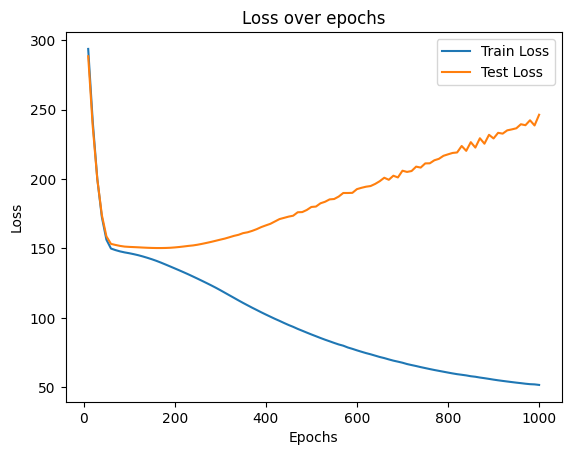

In [155]:
losses_graph = np.array(losses_graph)
plt.plot(losses_graph[:, 0], losses_graph[:, 1], label='Train Loss')
plt.plot(losses_graph[:, 0], losses_graph[:, 2], label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [156]:
print(len(test_outputs))
print(testing_target_tensor[0])

prediction = []
truth = []
delta = []
accuracy = []
for result in range(len(test_outputs)):
    print(f'Test: {test_outputs[result][0].item()} \t Truth: {testing_target_tensor[result][0].item()}')
    if result % 100 == 0:
        prediction.append(test_outputs[result][0].item())
        truth.append(testing_target_tensor[result][0].item())
        delta.append(testing_target_tensor[result][0].item()-test_outputs[result][0].item())
        
print(len(truth), len(prediction))


115794
tensor([1.])
Test: 6.5752410888671875 	 Truth: 1.0
Test: 23.166336059570312 	 Truth: 32.0
Test: 10.855803489685059 	 Truth: 1.0
Test: 10.334029197692871 	 Truth: 7.0
Test: 28.84832763671875 	 Truth: 21.0
Test: 3.7820441722869873 	 Truth: 2.0
Test: 9.42532730102539 	 Truth: 17.0
Test: 17.516454696655273 	 Truth: 20.0
Test: 1.3507144451141357 	 Truth: 1.0
Test: 1.419884443283081 	 Truth: 1.0
Test: 3.730163335800171 	 Truth: 1.0
Test: 10.487224578857422 	 Truth: 2.0
Test: 6.185301303863525 	 Truth: 24.0
Test: 5.176243782043457 	 Truth: 5.0
Test: 4.244231224060059 	 Truth: 2.0
Test: 4.942636013031006 	 Truth: 2.0
Test: 0.10799676179885864 	 Truth: 1.0
Test: 3.637460470199585 	 Truth: 4.0
Test: 1.8601272106170654 	 Truth: 1.0
Test: 0.824876606464386 	 Truth: 1.0
Test: 3.6462562084198 	 Truth: 11.0
Test: 4.396495819091797 	 Truth: 7.0
Test: 6.984578609466553 	 Truth: 4.0
Test: 0.18223649263381958 	 Truth: 4.0
Test: 13.162250518798828 	 Truth: 21.0
Test: 12.386115074157715 	 Truth: 40.

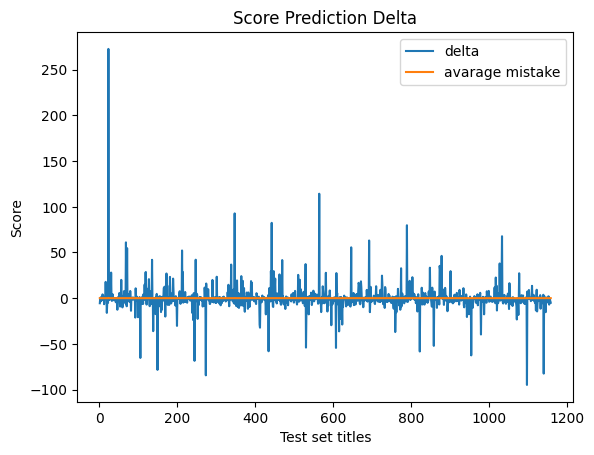

In [157]:

# plt.plot(range(1, len(truth)+1), prediction, label='Prediction')
# plt.plot(range(1, len(truth)+1), truth, label='Truth')
plt.plot(range(1, len(truth)+1), delta, label='delta')
plt.plot(range(1, len(truth)+1), np.array(delta)/len(truth), label='avarage mistake')
# plt.ylim(-10, 10)
plt.title('Score Prediction Delta')
plt.xlabel('Test set titles')
plt.ylabel('Score')
plt.legend()
plt.show()

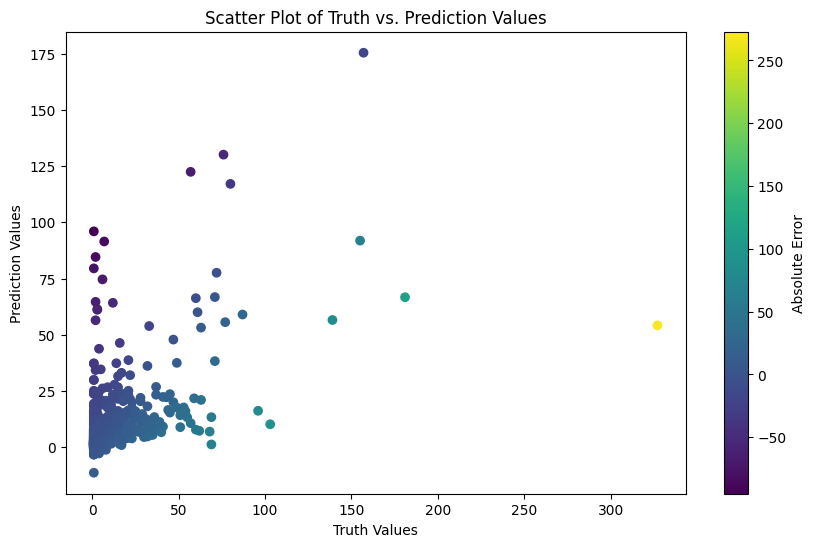

In [158]:
plt.figure(figsize=(10, 6))
plt.scatter(truth, prediction, c=delta, cmap='viridis')
plt.colorbar(label='Absolute Error')
plt.xlabel('Truth Values')
plt.ylabel('Prediction Values')
plt.title('Scatter Plot of Truth vs. Prediction Values')
plt.show()

Accuracy: 624.79%
Accuracy: 229.18%


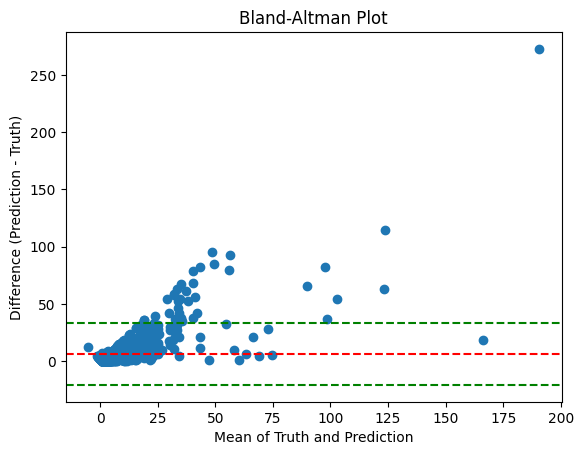

In [159]:
from sklearn.metrics import mean_squared_error
mean = (np.array(truth) + np.array(prediction)) / 2
delta = np.abs(np.array(truth) - np.array(prediction))
accuracy = np.sum(delta) / len(truth) *100

print(f"Accuracy: {accuracy:.2f}%")

accuracy = mean_squared_error(np.array(truth), np.array(prediction))
print(f"Accuracy: {accuracy:.2f}%")

# Bland-Altman Plot
plt.scatter(mean, delta)
plt.axhline(y=np.mean(delta), color='r', linestyle='--')
plt.axhline(y=np.mean(delta) + 1.96*np.std(delta), color='g', linestyle='--')
plt.axhline(y=np.mean(delta) - 1.96*np.std(delta), color='g', linestyle='--')
plt.title('Bland-Altman Plot')
plt.xlabel('Mean of Truth and Prediction')
plt.ylabel('Difference (Prediction - Truth)')
plt.show()

In [72]:
torch.save(Model.state_dict(), 'model_Alex_weights.pth')
print('Model weights saved.')

Model weights saved.
